In [1]:
%load_ext autoreload

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%autoreload 2
from subgrid_parameterization.preprocess.mixing_length import compute_mixing_length
from subgrid_parameterization.preprocess import SAM_helpers as sam

In [3]:
path = '/glade/work/stepheba/clubb_tutorial/pdf_slides/sam-bomex/'
file = 'BOMEX_64x64x75_100m_40m_1s'
# file = 'BOMEX_3d'

# path = '/glade/work/stepheba/clubb_tutorial/pdf_slides/sam-rf01/'
# file = 'DYCOMS_RF01_96x96x320'
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = '/glade/work/stepheba/clubb_tutorial/pdf_slides/sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

ds=xr.open_dataset(path+file+'.nc')
ds

<xarray.Dataset> Size: 47MB
Dimensions:      (x: 1, y: 1, z: 75, time: 360)
Coordinates:
  * x            (x) float32 4B -56.5
  * y            (y) float32 4B 15.0
  * z            (z) float32 300B 20.0 60.0 100.0 ... 2.9e+03 2.94e+03 2.98e+03
  * time         (time) datetime64[ns] 3kB 1969-06-22T00:01:00 ... 1969-06-22...
Data variables: (12/446)
    p            (z) float32 300B ...
    PREC         (time) float32 1kB ...
    CWP          (time) float32 1kB ...
    IWP          (time) float32 1kB ...
    RWP          (time) float32 1kB ...
    SWP          (time) float32 1kB ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 108kB ...
    RTPNRP_IP    (time, z, y, x) float32 108kB ...
    THLPNRP_IP   (time, z, y, x) float32 108kB ...
    RRPNRP_IP    (time, z, y, x) float32 108kB ...
    RRP3_IP      (time, z, y, x) float32 108kB ...
    NRP3_IP      (time, z, y, x) float32 108kB ...
Attributes:
    SAM version:  
    caseid:       64x64x75_100m_40m_1s
    Conventions:  COARDS

In [4]:
ngrdcol = len(ds['time']) # Sub time for space for this index

In [5]:
# Pass instead of 'grid' object
nzm, nzt, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.stagger_grid(ds)

In [6]:
thvm = sam.stagger_var('THETAV',ds,zt)
thlm = sam.stagger_var('THETAL',ds,zt)
rtm = sam.stagger_var('RTM',ds,zt)

In [7]:
U2 = sam.stagger_var('U2',ds,zm)
V2 = sam.stagger_var('V2',ds,zm)
W2 = sam.stagger_var('W2',ds,zm)
em = 0.5*np.sqrt(U2 + V2 + W2)

In [8]:
Lscale_max = 0.25*64*100 # 64 pts * 100 m dx_LES = dx_GCM, CLUBB takes 1/4 this for max when implemented

In [9]:
p_in_Pa = sam.stagger_var('p',ds,zt)*100 # p in mb * 10^-3 bar/mb * 10^5 Pa/bar 

In [10]:
exner = sam.stagger_var('TABS',ds,zt) / sam.stagger_var('THETA',ds,zt) # Calc as (p/p0)^(Rd/Cp) instead?

In [11]:
thv_ds = sam.stagger_var('THETA',ds,zt) # Not sure how to get 'base-state' from LES. From *.F90: ! Dry, base-state theta_v on thermodynamic level [K]

In [12]:
# ! mu = (1/M) dM/dz > 0.  mu=0 for no entrainment.
# Siebesma recommends mu=2e-3, although most schemes use mu=1e-4
#     ! When mu was fixed, we used the value mu = 6.e-4
mu = np.full(ngrdcol,6.e-4) # How to get this as a function varying by column?

In [13]:
lmin = 20.0 # (lmin_coeff=0.5)*(lmin_deltaz = 40)

In [14]:
saturation_formula = 1
l_implemented = True

In [15]:
compute_mixing_length(nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt, thvm, thlm, rtm, em, Lscale_max, p_in_Pa, exner, thv_ds, mu, lmin, saturation_formula, l_implemented)

(360,)
(360, 1)
(37, 1)
(360, 37)
(360, 1, 37)


NameError: name 'zm2zt' is not defined

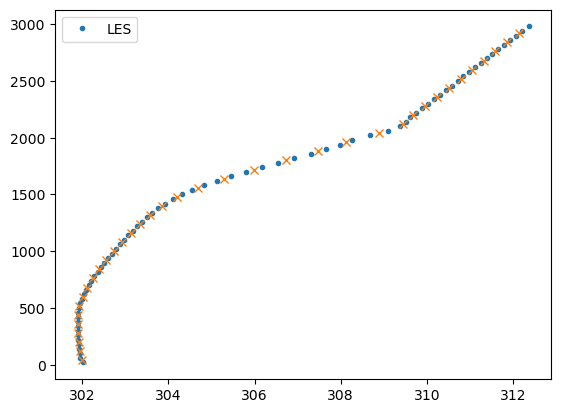

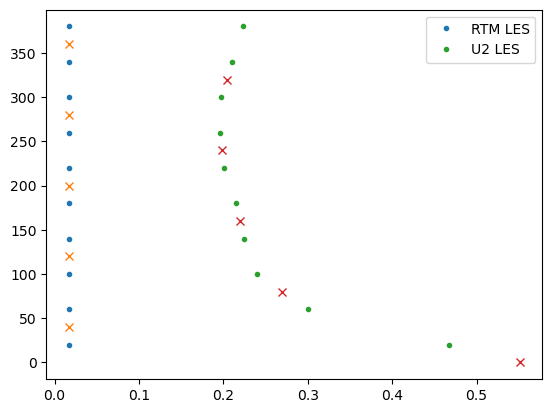

In [16]:
z = ds['z']

plt.figure()
plt.plot(ds['THETAV'][-1].squeeze().values,z,'.',label='LES')
plt.plot(thvm[-1],zt,'x')
plt.legend()

plt.figure()
plt.plot(ds['RTM'][-1].squeeze().values[:10],z[:10],'.',label='RTM LES')
plt.plot(rtm[-1,:5],zt[:5],'x')
plt.plot(ds['U2'][-1].squeeze().values[:10],z[:10],'.',label='U2 LES')
plt.plot(U2[-1,:5],zm[:5],'x')
plt.legend()